In [1]:
# =============================================================
# 0. IMPORT LIBRARIES
# =============================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
import warnings
warnings.filterwarnings("ignore")


# =============================================================
# 1. LOAD & CLEAN DATASET UTAMA (DIABETES MODEL)
# =============================================================
df = pd.read_csv("../Dataset/data_labeled.csv", sep=';')
df = df.replace(',', '.', regex=True)
df.columns = df.columns.str.strip().str.lower()

for col in df.columns:
    if col != 'status':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()


# =============================================================
# 2. FEATURE ENGINEERING (HARUS KONSISTEN)
# =============================================================
df["insulin_log"] = np.log1p(df["insulin"])
# 🔥 Model hanya pakai fitur ini
model_features = ["bmi", "age", "fgb", "avg_systolyc", "avg_dystolyc", "insulin_log"]

X = df[model_features]
y = df["status"]

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)


# =============================================================
# 3. TRAIN/TEST SPLIT TANPA SMOTE (pakai data asli)
# =============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================
#  HITUNG SAMPLE WEIGHT (class-weight)
# =============================================================
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# =============================================================
# TRAIN XGBOOST WITH RANDOM SEARCH (pakai sample_weight)
# =============================================================
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.4),
    'min_child_weight': randint(1, 5)
}

random_search = RandomizedSearchCV(
    xgb,
    param_dist,
    n_iter=40,
    cv=5,
    scoring='accuracy',
    random_state=42,
    verbose=0,
    n_jobs=-1
)

print("Training model...")
random_search.fit(
    X_train_scaled,
    y_train,
    **{'sample_weight': sample_weights}
)

best_xgb = random_search.best_estimator_
class_counts = pd.Series(y_train).value_counts()
print("\n=== JUMLAH PER KELAS TRAIN (SEBELUM BALANCING) ===")
print(class_counts)

classes = le.classes_
print("\n=== BOBOT YANG DIPAKAI MODEL (class-weight) ===")
for c, w in zip(classes, np.unique(sample_weights)):
    print(f"{c}: {w:.2f}")

# =============================================================
#  EVALUATION
# =============================================================
pred_test = best_xgb.predict(X_test_scaled)
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, pred_test, target_names=le.classes_))



# =============================================================
# 6. LOAD FOOD DATASET
# =============================================================
df_food = pd.read_csv("../Dataset/foods_prepared.csv",delimiter=";")

# pastikan semua numeric
numeric_cols = ["energy_kcal", "carbs", "protein_g", "fat_g", "freesugar_g",
                "fibre_g", "cholestrol_mg", "calcium_mg"]

for col in numeric_cols:
    df_food[col] = pd.to_numeric(df_food[col], errors="coerce").fillna(0)


# =============================================================
# 7. USER INPUT (MODEL PREDIKSI)
# =============================================================
print("\n=== INPUT DATA PASIEN BARU ===")

user_raw_features = ["bmi", "age", "fgb", "avg_systolyc", "avg_dystolyc", "insulin"]
user_input = {}

for col in user_raw_features:
    while True:
        try:
            val = float(input(f"Masukkan nilai untuk {col}: "))
            user_input[col] = val
            break
        except:
            print("Input harus angka!")

# 🔥 Transformasi otomatis (sama dengan training)
user_input["insulin_log"] = np.log1p(user_input["insulin"])

# Data final sesuai urutan
final_data = {
    "bmi": user_input["bmi"],
    "age": user_input["age"],
    "fgb": user_input["fgb"],
    "avg_systolyc": user_input["avg_systolyc"],
    "avg_dystolyc": user_input["avg_dystolyc"],
    "insulin_log": user_input["insulin_log"]
}

new_df = pd.DataFrame([final_data], columns=model_features)
new_scaled = scaler.transform(new_df)

# Predict
pred_prob = best_xgb.predict_proba(new_scaled)[0]
pred_class = np.argmax(pred_prob)
pred_label_user = le.inverse_transform([pred_class])[0]
confidence = pred_prob[pred_class] * 100

print("\n=== HASIL PREDIKSI PASIEN BARU ===")
print(f"Prediksi Status : {pred_label_user} ({confidence:.2f}%)")
print("\nProbabilitas Detail:")
for label, prob in zip(le.classes_, pred_prob):
    print(f"  - {label}: {prob*100:.2f}%")


# =============================================================
# 8. NORMALISASI STATUS
# =============================================================
def normalize_status(label):
    t = label.lower().replace("-", "").replace(" ", "")
    if t in ["nondiabetes", "nondiabetic", "normal"]:
        return "Non-Diabetic"
    if t in ["prediabetes", "prediabetic"]:
        return "Prediabetic"
    if t in ["diabetes", "diabetic"]:
        return "Diabetic"
    return "Non-Diabetic"


status_norm = normalize_status(pred_label_user)


# =============================================================
# 9. RULE MAKANAN
# =============================================================
def get_rules(status):
    if status == "Non-Diabetic":
        return {"max_sugar":20,"max_fat":20,"min_protein":5,
                "max_carbs":60,"max_chol":300,"min_fibre":2,
                "cal_min":150,"cal_max":600}

    if status == "Prediabetic":
        return {"max_sugar":10,"max_fat":15,"min_protein":8,
                "max_carbs":45,"max_chol":250,"min_fibre":3,
                "cal_min":150,"cal_max":500}

    return {"max_sugar":5,"max_fat":10,"min_protein":10,
            "max_carbs":35,"max_chol":200,"min_fibre":4,
            "cal_min":120,"cal_max":450}


# =============================================================
# 10. FILTER FOOD
# =============================================================
def filter_food(df, rules):
    return df[
        (df["freesugar_g"] <= rules["max_sugar"]) &
        (df["fat_g"] <= rules["max_fat"]) &
        (df["protein_g"] >= rules["min_protein"]) &
        (df["carbs"] <= rules["max_carbs"]) &
        (df["cholestrol_mg"] <= rules["max_chol"]) &
        (df["fibre_g"] >= rules["min_fibre"]) &
        (df["energy_kcal"] >= rules["cal_min"]) &
        (df["energy_kcal"] <= rules["cal_max"])
    ]


# =============================================================
# 11. MEAL PLAN
# =============================================================
def recommend_meal(df, status):
    rules = get_rules(status)
    df_filtered = filter_food(df, rules)

    if len(df_filtered) < 3:
        return "⚠️ Makanan terlalu sedikit!"

    return {
        "breakfast": df_filtered.sample(1).iloc[0]["fooditems"],
        "lunch": df_filtered.sample(1).iloc[0]["fooditems"],
        "dinner": df_filtered.sample(1).iloc[0]["fooditems"]
    }


meal_plan = recommend_meal(df_food, status_norm)


# =============================================================
# 12. SHOW NUTRITION
# =============================================================
def show_nutrition(df, food):
    r = df[df["fooditems"].str.lower()==food.lower()]
    if r.empty:
        print("Nutrisi tidak ditemukan:", food)
        return
    r = r.iloc[0]
    print(f"\n📌 Nutrisi {food}")
    print(f"  Energi : {r['energy_kcal']} kcal")
    print(f"  Karbo  : {r['carbs']} g")
    print(f"  Protein: {r['protein_g']} g")
    print(f"  Lemak  : {r['fat_g']} g")
    print(f"  Gula   : {r['freesugar_g']} g")
    print(f"  Serat  : {r['fibre_g']} g")
    print(f"  Kolest : {r['cholestrol_mg']} mg")
print("\n=== 🍽 Rekomendasi Meal Plan ===")
if isinstance(meal_plan, str):
    print(meal_plan)
else:
    print("🍳 Sarapan:", meal_plan["breakfast"])
    print("🍛 Siang  :", meal_plan["lunch"])
    print("🍽 Malam :", meal_plan["dinner"])

    show_nutrition(df_food, meal_plan["breakfast"])
    show_nutrition(df_food, meal_plan["lunch"])
    show_nutrition(df_food, meal_plan["dinner"])


Training model...

=== JUMLAH PER KELAS TRAIN (SEBELUM BALANCING) ===
0    2353
2    1041
1    1036
Name: count, dtype: int64

=== BOBOT YANG DIPAKAI MODEL (class-weight) ===
Diabetes: 0.63
Non-diabetes: 1.42
Prediabetes: 1.43

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    Diabetes       0.97      0.96      0.96       588
Non-diabetes       0.85      0.93      0.88       259
 Prediabetes       0.88      0.81      0.84       261

    accuracy                           0.92      1108
   macro avg       0.90      0.90      0.90      1108
weighted avg       0.92      0.92      0.92      1108


=== INPUT DATA PASIEN BARU ===

=== HASIL PREDIKSI PASIEN BARU ===
Prediksi Status : Diabetes (99.29%)

Probabilitas Detail:
  - Diabetes: 99.29%
  - Non-diabetes: 0.53%
  - Prediabetes: 0.19%

=== 🍽 Rekomendasi Meal Plan ===
🍳 Sarapan: EdamameBoiled
🍛 Siang  : EdamameBoiled
🍽 Malam : Paneerstuffedcheela/chilla

📌 Nutrisi EdamameBoiled
  Energi : 121.0 kcal


Training model...

Jumlah data sebelum class weight:
  Class Diabetes: 701 sample
  Class Non-diabetes: 279 sample
  Class Prediabetes: 188 sample

Rata-rata bobot setelah class weight:
  Class Diabetes: weight rata-rata = 0.5554
  Class Non-diabetes: weight rata-rata = 1.3955
  Class Prediabetes: weight rata-rata = 2.0709

Jumlah data pada TESTING set:
  Class Diabetes: 175 sample
  Class Non-diabetes: 70 sample
  Class Prediabetes: 47 sample

==================== MODEL ACCURACY ====================
Accuracy: 0.9383561643835616

==================== CLASSIFICATION REPORT ====================
              precision    recall  f1-score   support

    Diabetes       0.96      1.00      0.98       175
Non-diabetes       0.90      0.89      0.89        70
 Prediabetes       0.90      0.79      0.84        47

    accuracy                           0.94       292
   macro avg       0.92      0.89      0.90       292
weighted avg       0.94      0.94      0.94       292



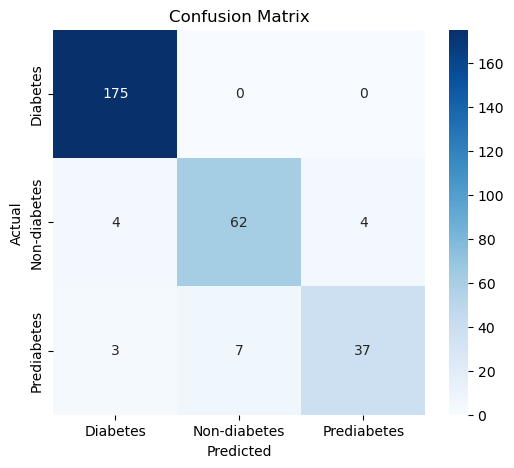

SHAP shape: (292, 6, 3)

Index sample per kelas:
Non-diabetes : 0
Prediabetes  : 3
Diabetes     : 1



SHAP force plot — Sample #0 | Class = Diabetes


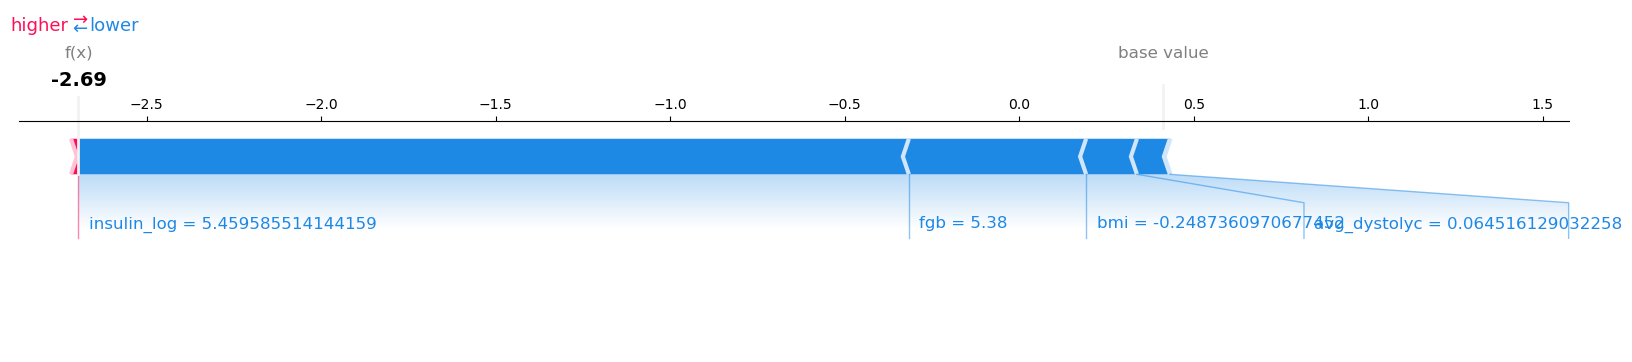


SHAP force plot — Sample #3 | Class = Non-diabetes


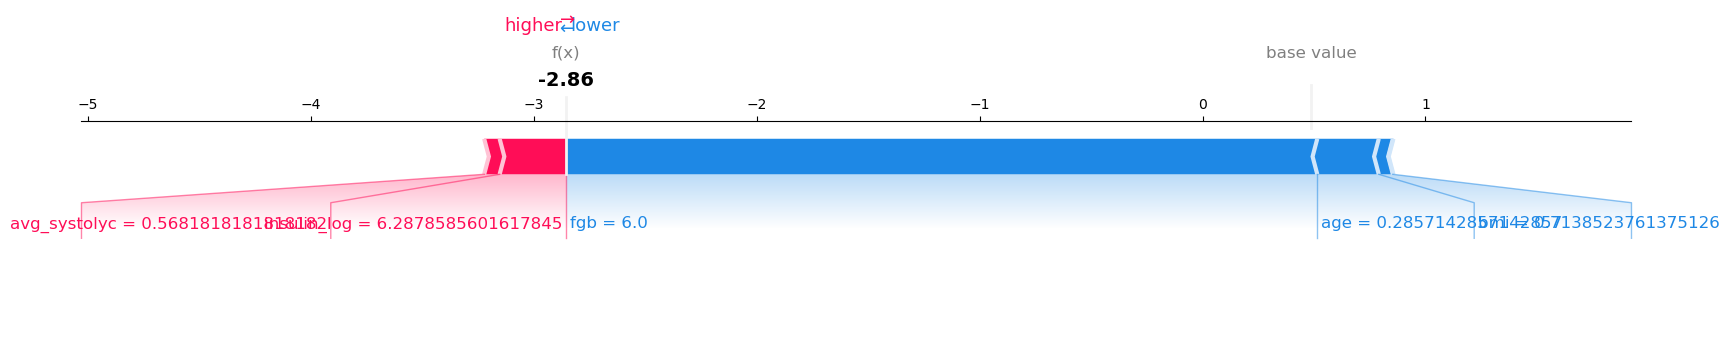


SHAP force plot — Sample #1 | Class = Prediabetes


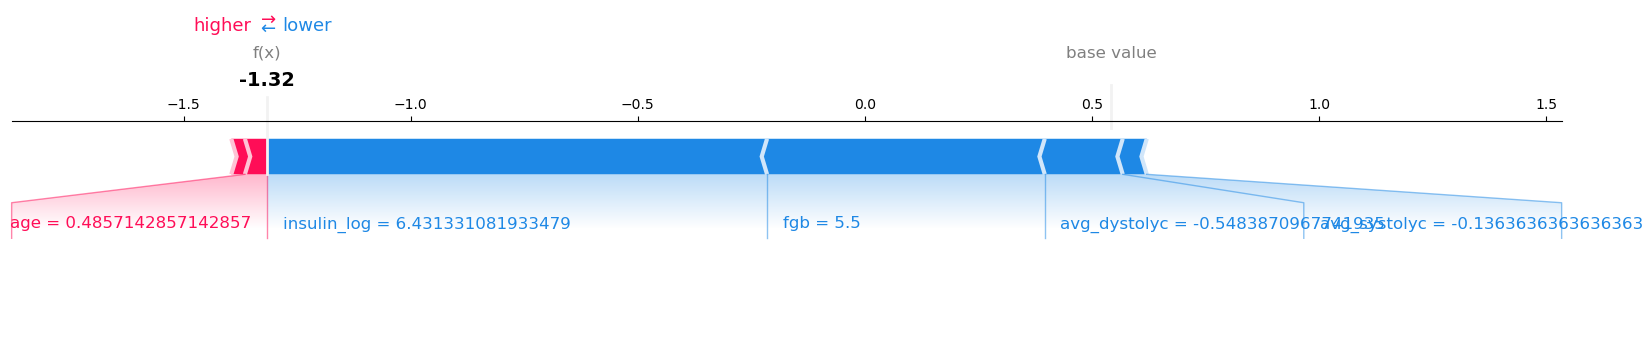

In [1]:
# =============================================================
# 0. IMPORT LIBRARIES
# =============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings("ignore")

# =============================================================
# 1. LOAD & CLEAN DATASET
# =============================================================
df = pd.read_csv("../Dataset/data_scaled_clean.csv", sep=';')
df = df.replace(',', '.', regex=True)
df.columns = df.columns.str.strip().str.lower()

# convert numeric
for col in df.columns:
    if col != 'status':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

# =============================================================
# 2. FEATURE ENGINEERING
# =============================================================
df["insulin_log"] = np.log1p(df["insulin"])

model_features = ["bmi", "age", "fgb", "avg_systolyc", "avg_dystolyc", "insulin_log"]

X = df[model_features]
y = df["status"]

# encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# =============================================================
# 3. SPLIT + SCALING
# =============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================
# 4. CLASS WEIGHT
# =============================================================
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# =============================================================
# 5. TRAIN XGBOOST (Random Search)
# =============================================================
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.4),
    'min_child_weight': randint(1, 5)
}

random_search = RandomizedSearchCV(
    xgb,
    param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

print("Training model...")
random_search.fit(X_train_scaled, y_train, sample_weight=sample_weights)

best_xgb = random_search.best_estimator_

# =============================================================
# 6. PREDICTION
# =============================================================
pred_test = best_xgb.predict(X_test_scaled)
# ==== Tampilkan distribusi sebelum class weight ====
unique, counts = np.unique(y_train, return_counts=True)
print("\nJumlah data sebelum class weight:")
for u, c in zip(unique, counts):
    print(f"  Class {le.classes_[u]}: {c} sample")

# ==== Tampilkan rata-rata bobot class weight setelah balanced ====
print("\nRata-rata bobot setelah class weight:")
for u in unique:
    avg_w = sample_weights[y_train == u].mean()
    print(f"  Class {le.classes_[u]}: weight rata-rata = {avg_w:.4f}")
    # ==== Distribusi data test ====
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nJumlah data pada TESTING set:")
for u, c in zip(unique_test, counts_test):
    print(f"  Class {le.classes_[u]}: {c} sample")

# =============================================================
# 7. EVALUATION REPORT
# =============================================================
print("\n==================== MODEL ACCURACY ====================")
print("Accuracy:", accuracy_score(y_test, pred_test))

print("\n==================== CLASSIFICATION REPORT ====================")
print(classification_report(y_test, pred_test, target_names=le.classes_))

# =============================================================
# 8. CONFUSION MATRIX + HEATMAP
# =============================================================
cm = confusion_matrix(y_test, pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =============================================================
# 10. EXPLAINABLE AI — SHAP (GLOBAL + LOCAL)
# =============================================================
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_scaled)

print("SHAP shape:", np.array(shap_values).shape)

# ==================== FIX: Convert y_test to original labels ====================
y_test_labels = le.inverse_transform(y_test)   # bentuk: array of string labels

# -------------------------------------------------------------
# AMBIL SAMPLE UNTUK SETIAP KELAS
# -------------------------------------------------------------
idx_non = np.where(y_test_labels == "Non-diabetes")[0][0]
idx_pre = np.where(y_test_labels == "Prediabetes")[0][0]
idx_dia = np.where(y_test_labels == "Diabetes")[0][0]

print("\nIndex sample per kelas:")
print("Non-diabetes :", idx_non)
print("Prediabetes  :", idx_pre)
print("Diabetes     :", idx_dia)

# -------------------------------------------------------------
# FUNGSI UNTUK FORCE PLOT
# -------------------------------------------------------------
def plot_force_for_class(idx, class_id):
    sv_single = shap_values[idx, :, class_id]
    print(f"\nSHAP force plot — Sample #{idx} | Class = {le.classes_[class_id]}")
    shap.force_plot(
        explainer.expected_value[class_id],
        sv_single,
        X_test.iloc[idx],
        matplotlib=True
    )

# -------------------------------------------------------------
# TAMPILKAN FORCE PLOT UNTUK 3 KELAS
# -------------------------------------------------------------
shap.initjs()

plot_force_for_class(idx_non, 0)   # Non-diabetes
plot_force_for_class(idx_pre, 1)   # Prediabetes
plot_force_for_class(idx_dia, 2)   # Diabetes


Tuning Random Forest (Primary Base)...
Best Random Forest Params Found.

Training Stacking Ensemble...

Accuracy: 0.9202127659574468
              precision    recall  f1-score   support

    Diabetes       0.97      0.97      0.97       296
Non-diabetes       0.85      0.91      0.88       138
 Prediabetes       0.89      0.81      0.85       130

    accuracy                           0.92       564
   macro avg       0.90      0.90      0.90       564
weighted avg       0.92      0.92      0.92       564



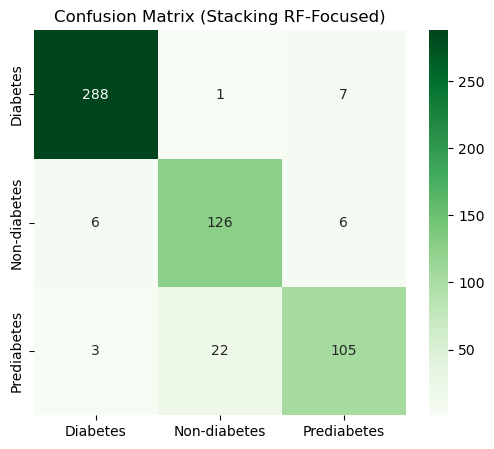

In [1]:
# =============================================================
# 0. IMPORT LIBRARIES
# =============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.stats import randint, uniform
from sklearn.utils.class_weight import compute_sample_weight

# MODEL IMPORTS
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# =============================================================
# 1. LOAD & CLEAN DATASET
# =============================================================
df = pd.read_csv("../Dataset/data_scaled_clean.csv", sep=';')
df = df.replace(',', '.', regex=True)
df.columns = df.columns.str.strip().str.lower()

# Pilih fitur penting (agar dropna aman)
raw_features = ["bmi", "age", "fgb", "avg_systolyc", "avg_dystolyc", "insulin", "status"]
df = df[raw_features]

# Convert ke numeric
for col in raw_features:
    if col != 'status':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

# =============================================================
# 2. FEATURE ENGINEERING
# =============================================================
df["insulin_log"] = np.log1p(df["insulin"])

model_features = ["bmi", "age", "fgb", "avg_systolyc", "avg_dystolyc", "insulin_log"]

X = df[model_features]
y = df["status"]

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# =============================================================
# 3. SPLIT + SCALING
# =============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_df = pd.DataFrame(X_test_scaled, columns=model_features)

# =============================================================
# 4. CLASS WEIGHT
# =============================================================
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# =============================================================
# 5. PREPARE BASE MODELS (RF is now the PRIMARY)
# =============================================================

# --- A. Tuning Random Forest (Base Model 1 - PRIMARY) ---
print("Tuning Random Forest (Primary Base)...")
rf_base = RandomForestClassifier(random_state=42)

# Grid Parameter khusus Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

random_search_rf = RandomizedSearchCV(
    rf_base, param_dist_rf, n_iter=15, cv=3, scoring='accuracy', random_state=42, n_jobs=-1
)
random_search_rf.fit(X_train_scaled, y_train, sample_weight=sample_weights)
best_rf = random_search_rf.best_estimator_
print("Best Random Forest Params Found.")

# --- B. XGBoost (Base Model 2 - SECONDARY) ---
# Gunakan parameter standar/default saja
xgb_base = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False, 
    eval_metric='mlogloss',
    random_state=42
)

# =============================================================
# 6. BUILD STACKING (RF Optimized + XGB Standard)
# =============================================================
estimators = [
    ('rf', best_rf),   # Tuned RF
    ('xgb', xgb_base)  # Standard XGB
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

print("\nTraining Stacking Ensemble...")
stack_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# =============================================================
# 7. EVALUATION
# =============================================================
pred_test = stack_model.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test, pred_test))
print(classification_report(y_test, pred_test, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Stacking RF-Focused)")
plt.show()

